In [1]:
%cd supervised
%load_ext autoreload
%autoreload 2

import data
import train
import evaluate
import models
import torch

/home/maarten/Documents/masterthesis/supervised


# Dataset analysis

In [ ]:
import glob
from lxml import etree

positives = []
negatives = []
for path in glob.glob('../training_data/*.xml'):
    with open(path, 'r') as f:
        xml = etree.fromstring(f.read().encode('utf-8'))
    pos = len(xml.xpath('/pdf2xml/page/text[@is-speech="true"]'))
    neg = len(xml.xpath('/pdf2xml/page/text[@is-speech="false"]'))
    positives.append(pos)
    negatives.append(neg)

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from tabulate import tabulate

sns.distplot(positives, axlabel='positive samples per file')
fig = plt.gcf()
plt.show()
fig.savefig('distribution.pdf')

print(tabulate([['Positives samples', sum(positives)],
                ['Negative samples', sum(negatives)]]))

# Training and evaluation

In [2]:
num_clusters = 5
window_size = 11
window_label = 6

files = [f'../clusterlabeled-fixed-{num_clusters}/18{i:03d}.xml' for i in [1, 2, 3]]
test_files = [f'../clusterlabeled-fixed-{num_clusters}/18{i:03d}.xml' for i in [1]]

full_window_dataset = data.GermanDataset(files, num_clusters, 20000, 10000, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.FULL_WINDOW)
only_center_dataset = data.GermanDataset(files, num_clusters, 20000, 10000, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.ONLY_CENTRAL)
only_idx_dataset = data.GermanDataset(files, num_clusters, 20000, 10000, window_size, window_label,
                                        cluster_fmt=data.ClusterFmt.FULL_WINDOW_ONLY_IDX)

Creating dictionary:  67%|██████▋   | 2/3 [00:00<00:00, 15.10it/s]

Retrieved 584 positive samples, 28169 negative samples.


Creating dictionary:  67%|██████▋   | 2/3 [00:00<00:00, 17.67it/s]

Retrieved 584 positive samples, 28169 negative samples.


  3%|▎         | 584/20000 [00:11<06:18, 51.28it/s]


Retrieved 584 positive samples, 28169 negative samples.


# Test the different kinds of cluster handling
# 1000 samples

In [35]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.0,
    epochs=50,
    filters=[(33, 3), (34, 5), (33, 7)],
    num_layers=1
)

optim_fn = lambda p: torch.optim.Adadelta(p, weight_decay=1e-3)

no_labels = evaluate.cross_val(5, lambda r: models.NoClusterLabels(r, params.dropout),
                                 optim_fn, only_idx_dataset.split((500, 500)), params)
only_center = evaluate.cross_val(5, lambda r: models.CategoricalClusterLabelsOnlyCenter(r, num_clusters, params.dropout),
                                 optim_fn, only_center_dataset.split((500, 500)), params)
full_window = evaluate.cross_val(5, lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
                                 optim_fn, full_window_dataset.split((500, 500)), params)
with_cnn = evaluate.cross_val(5, lambda r: models.ClusterLabelsCNN(r, num_clusters, params.dropout),
                              optim_fn, only_idx_dataset.split((500, 500)), params)

Training: 100%|██████████| 50/50 [00:16<00:00,  3.01it/s, loss=0.000892, Δloss=2.09e-05] 


Average convergence speed


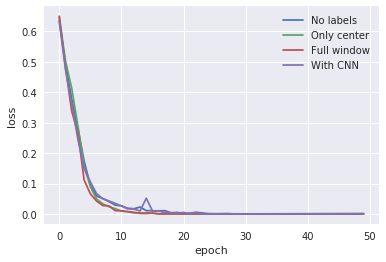


Average P/R curve


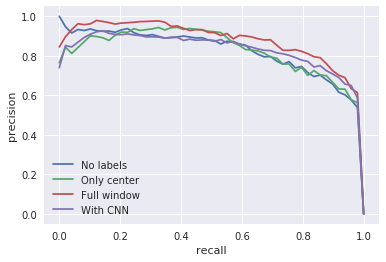


Score table:
               F1 mean    F1 stddev    AoC mean    AoC std    Area under averaged curve
-----------  ---------  -----------  ----------  ---------  ---------------------------
No labels     0.7882      0.0263339    0.765623  0.0484467                     0.82465
Only center   0.793557    0.0297527    0.76825   0.0360068                     0.825961
Full window   0.831201    0.0213846    0.816999  0.04137                       0.878208
With CNN      0.816268    0.0235298    0.776905  0.023674                      0.829794

AP plots:


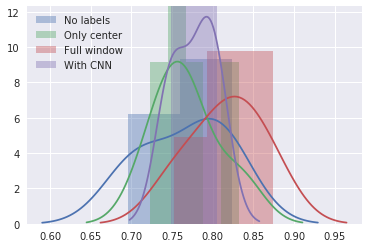

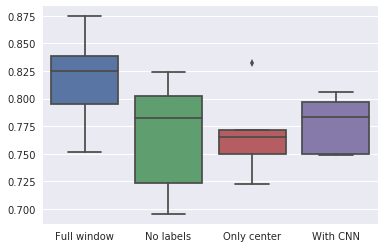

F1 plots:


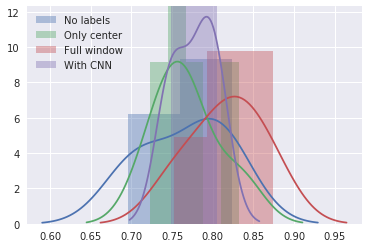

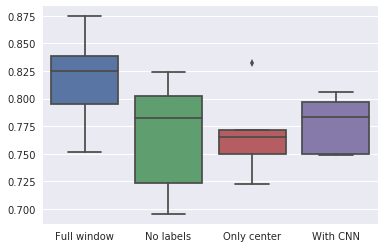

In [38]:
evaluate.analyze({'No labels': no_labels,
                  'Only center': only_center,
                  'Full window': full_window,
                  'With CNN': with_cnn})

## 500 samples

In [39]:
params = train.CNNParams(
    embed_size=300,
    dropout=0.0,
    epochs=50,
    filters=[(33, 3), (34, 5), (33, 7)],
    num_layers=1
)

optim_fn = lambda p: torch.optim.Adadelta(p, weight_decay=1e-3)

no_labels = evaluate.cross_val(5, lambda r: models.NoClusterLabels(r, params.dropout),
                                 optim_fn, only_idx_dataset.split((250, 250)), params)
only_center = evaluate.cross_val(5, lambda r: models.CategoricalClusterLabelsOnlyCenter(r, num_clusters, params.dropout),
                                 optim_fn, only_center_dataset.split((250, 250)), params)
full_window = evaluate.cross_val(5, lambda r: models.CategoricalClusterLabels(r, num_clusters, window_size, params.dropout),
                                 optim_fn, full_window_dataset.split((250, 250)), params)
with_cnn = evaluate.cross_val(5, lambda r: models.ClusterLabelsCNN(r, num_clusters, params.dropout),
                              optim_fn, only_idx_dataset.split((250, 250)), params)

Training: 100%|██████████| 50/50 [00:08<00:00,  6.24it/s, loss=0.000496, Δloss=7.14e-06] 


Average convergence speed


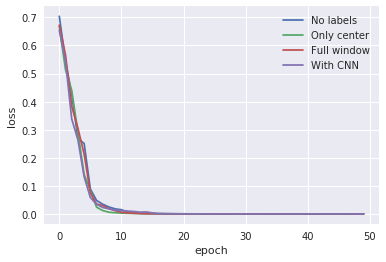


Average P/R curve


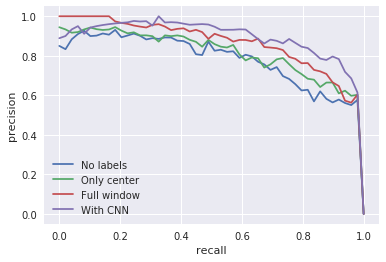


Score table:
               F1 mean    F1 stddev    AoC mean    AoC std    Area under averaged curve
-----------  ---------  -----------  ----------  ---------  ---------------------------
No labels     0.739042   0.0288693     0.74162   0.0295028                     0.781661
Only center   0.782148   0.0336425     0.775352  0.0376283                     0.814692
Full window   0.817002   0.00387985    0.792915  0.0238321                     0.865035
With CNN      0.85311    0.0224595     0.841463  0.0343082                     0.893359

AP plots:


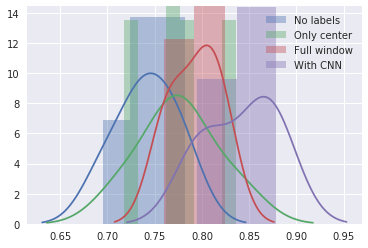

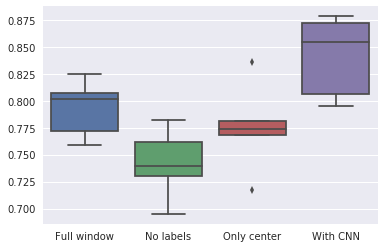

F1 plots:


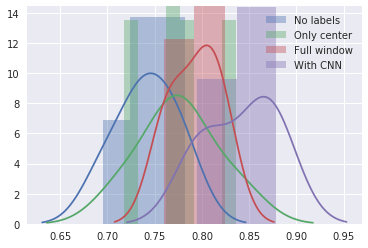

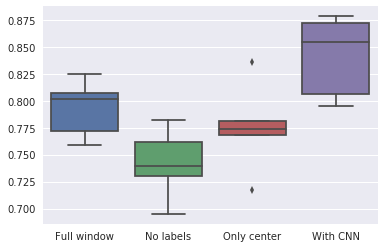

In [40]:
evaluate.analyze({'No labels': no_labels,
                  'Only center': only_center,
                  'Full window': full_window,
                  'With CNN': with_cnn})